## Setup ##

In [44]:
# imports 
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, 
import torch.nn.functional as F 
import torch.optim as optim

from torchvision import transforms

import numpy as np 
import pandas as pd
from skimage import io, measure
from PIL import Image
from datetime import datetime

import aug
from os.path import join, expanduser

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
matplotlib.rcParams['axes.grid'] = False

In [87]:
data_dir = join(expanduser('~'), 'defect_training/mip2')
output_dir = join(expanduser('~'), 'defect_training/mip2/output')
save_id = datetime.today().strftime('%Y%m%d')
phases = ['train', 'val']
label_ids = [1,2,3,4,5]

In [46]:
df = pd.read_csv(join(data_dir, 'data.csv'))
pos_df = df[df['is_positive']]
neg_df = df[~df['is_positive']]
pos_perm = np.random.permutation(len(pos_df))
neg_perm = np.random.permutation(len(neg_df))
pos_idx = 286
neg_idx = 66
train_df = pd.concat([pos_df.iloc[pos_perm[:pos_idx]], neg_df.iloc[neg_perm[:neg_idx]]], ignore_index=True)
val_df = pd.concat([pos_df.iloc[pos_perm[pos_idx:]], neg_df.iloc[neg_perm[neg_idx:]]], ignore_index=True)
train_df.to_csv(join(data_dir, 'train.csv'))
val_df.to_csv(join(data_dir, 'val.csv'))

# Dataset class

In [88]:
def normalize(image):
    return (image - np.mean(image)) / np.std(image)

def condense(image):
    mi = np.min(image)
    ma = np.max(image)
    return (image - mi) / (ma - mi) 

class DefectDataset(Dataset):
    
    def __init__(self, image_dir, label_dir, data_csv, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.df = pd.read_csv(data_csv, index_col=0)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def separate_labels(self, label):
        shape = (len(label_ids),) + label.shape
        o = np.zeros(shape).astype(np.float32)
        for k, l in enumerate(label_ids):
            o[k,:,:] = label == l
        return o
    
    def __getitem__(self, idx):
        image_fn = join(self.image_dir, self.df.iloc[idx,0])
        image = io.imread(image_fn).astype(np.float32)
        image = normalize(image)
        image = condense(image)
        
        is_positive = self.df.loc[idx,'is_positive']
        if is_positive:
            label_fn = join(self.label_dir, self.df.iloc[idx,0])
            label = io.imread(label_fn).astype(np.float32)
        else:
            label = np.zeros_like(image).astype(np.float32)
            
        label = self.separate_labels(label)
        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
            
        return sample    
    

## Transforms

In [89]:
def np2var(arr):
    while len(arr.shape) < 4:
        arr = np.expand_dims(arr, 0)
    arr = torch.from_numpy(arr)
    arr = Variable(arr)
    arr = arr.cuda()
    return arr

def var2np(arr):
    arr = arr.data.cpu().numpy()
    return arr

In [90]:
class Normalize(object):
    """Center and scale the image in a sample
    """
    def __call__(self, sample):
        image = sample['image']
        sample['image'] = normalize(image)
        return sample
    
class RandomBrightness(object):
    """Randomly adjust brightness of image in a sample
    """
    def __call__(self, sample):
        image = sample['image']
        sample['image'] = aug.aug_brightness(image)
        return sample    
    
class RandomRotateAndScale(object):
    """Random rotation and scaling of image and label in a sample
    """
    def __call__(self, sample):
        image, transform = aug.rotate_and_scale(sample['image'], size=None)
        label = F.grid_sample(sample['label'], transform)
        return {'image': image, 'label': label}
    
class RandomFlip(object):
    """Random flip over x or y axes, or x=y
    """
    def __call__(self, sample):
        r = np.random.randint(0,3)
        if r > 1:
            sample['image'] = np.flip(sample['image'], axis=1)
            sample['label'] = np.flip(sample['label'], axis=1)
        if r > 0:
            sample['image'] = np.flip(sample['image'], axis=0)
            sample['label'] = np.flip(sample['label'], axis=0)
        return sample
    
class ToTensor(object):
    """Convert image and label to tensor
    """
    def __call__(self, sample):
        image = np2var(sample['image'])
        label = np2var(sample['label'])
        return {'image': image, 'label': label}

In [91]:
composed = transforms.Compose([ToTensor(),
                               RandomRotateAndScale(),
                               RandomBrightness()])

In [92]:
datasets = {p: DefectDataset(join(data_dir, 'image'), 
                        join(data_dir, 'label'), 
                        join(data_dir, '{0}.csv'.format(p)), 
                        transform=composed) 
            for p in phases}

## Visualize Data ##

In [93]:
var2np(smp['image']).shape

(1, 1, 1024, 1024)

/usr/people/tmacrina/SEAMLeSS/defects/aug.py:142: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  mi, ma = torch.min(X).data[0], torch.max(X).data[0]


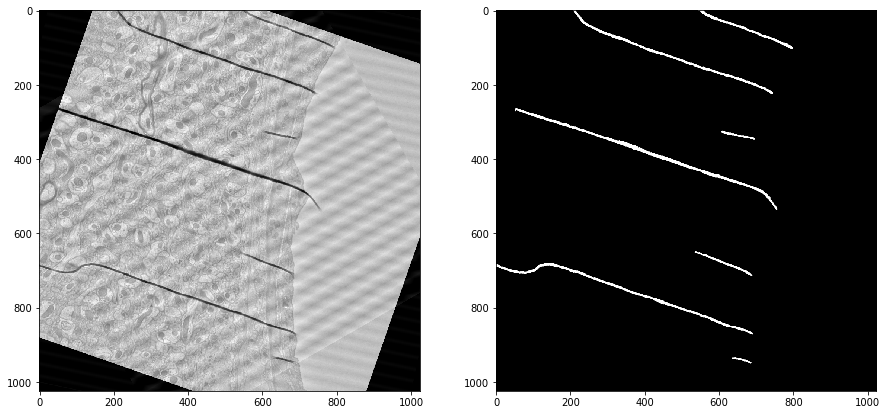

In [94]:
smp = datasets['train'][10]
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(var2np(smp['image'][0,0,:,:]), cmap='gray')
plt.subplot(122)
plt.imshow(np.sum(var2np(smp['label']), axis=(0,1)), cmap='gray')
plt.grid(False)
plt.show()

## Create UNet ##

In [101]:
# helper operations 
def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True)

def maxpool2x2():
    return nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

class UpConv2x2(nn.Module):
    def __init__(self, channels):
        super(UpConv2x2, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(channels, channels // 2,
            kernel_size=2, stride=1, padding=0, bias=True)

    def forward(self, x):
        x = self.upsample(x)
        x = F.pad(x, (0,1,0,1))
        x = self.conv(x)
        return x 
        
def concat(xh, xv):
    return torch.cat([xh, xv], dim=1)


# unet blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(ConvBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.conv3 = conv3x3(out_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class DownConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(DownConvBlock, self).__init__()
        self.maxpool = maxpool2x2()
        self.conv1 = conv3x3(in_channels, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.conv3 = conv3x3(out_channels, out_channels)

    def forward(self, x):
        x = self.maxpool(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(UpConvBlock, self).__init__()
        self.upconv = UpConv2x2(in_channels)
        self.conv1 = conv3x3(in_channels, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.conv3 = conv3x3(out_channels, out_channels)

    def forward(self, xh, xv):
        """
        Args:
            xh: torch Variable, activations from same resolution feature maps (gray arrow in diagram)
            xv: torch Variable, activations from lower resolution feature maps (green arrow in diagram)
        """
        xv = self.upconv(xv)
        x = concat(xh, xv)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        fs = [16,32,64,128,256]
        self.conv_in = ConvBlock(1, fs[0])
        self.dconv1 = DownConvBlock(fs[0], fs[1])
        self.dconv2 = DownConvBlock(fs[1], fs[2])
        self.dconv3 = DownConvBlock(fs[2], fs[3])
        self.dconv4 = DownConvBlock(fs[3], fs[4])

        self.uconv1 = UpConvBlock(fs[4], fs[3])
        self.uconv2 = UpConvBlock(fs[3], fs[2])
        self.uconv3 = UpConvBlock(fs[2], fs[1])
        self.uconv4 = UpConvBlock(fs[1], fs[0])
        self.conv_out = conv3x3(fs[0], len(label_ids))

        self._initialize_weights()

    def forward(self, x):
        x1 = self.conv_in(x)
        x2 = self.dconv1(x1)
        x3 = self.dconv2(x2)
        x4 = self.dconv3(x3)
        x5 = self.dconv4(x4)
        x6 = self.uconv1(x4, x5)
        x7 = self.uconv2(x3, x6)
        x8 = self.uconv3(x2, x7)
        x9 = self.uconv4(x1, x8)
        x10 = self.conv_out(x9)
        return x10

    def _initialize_weights(self):
        conv_modules = [m for m in self.modules() if isinstance(m, nn.Conv2d)]
        for m in conv_modules:
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, np.sqrt(2. / n))


## Train UNet ##

In [102]:
def plot(train_loss, val_loss, image, label, pred):
    clear_output(wait=False)
    plt.gcf().clear()
    
    x = 5
    y = 1 + len(label_ids)
    
    ax = plt.subplot(x,y,1)
    iters = np.arange(0,len(train_loss))
    train_plot, = plt.plot(iters, train_loss, 'r', label="training")
    val_plot, = plt.plot(iters, val_loss, 'b', label="validation")
    plt.title("Cross entropy loss")
    ax.set_yscale("log")

    plt.subplot(x,y,y+1)
    plt.imshow(var2np(image), cmap='gray')
    plt.title("Image")
    
    for k in range(len(label_ids)):
        plt.subplot(x,y,y+k+2)
        plt.imshow(var2np(F.sigmoid(pred[k])), cmap='gray')
        plt.title("Pred {0}".format(label_ids[k]))
        
        plt.subplot(x,y,2*y+k+2)
        plt.imshow(var2np(label[k]), cmap='gray')
        plt.title("Label {0}".format(label_ids[k]))

    plt.gcf().set_size_inches(18, 18)
    display(plt.gcf())

In [103]:
dataloaders = {}
dataloaders['train'] = DataLoader(datasets['train'], batch_size=4, shuffle=True, num_workers=4)
dataloaders['val'] = DataLoader(datasets['val'], batch_size=1, shuffle=True, num_workers=1)

In [104]:
## Train network ##

# params
epochs = 10 
lr = 0.00001

# create net
model = UNet()
model.cuda()
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
    
# create optimizer 
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = F.binary_cross_entropy_with_logits

def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    for batch_idx, sample in enumerate(dataloaders['train']):
        image = sample['image']
        label = sample['label']
        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss

def val(epoch):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, sample in enumerate(dataloaders['val']):
            image = sample['image']
            label = sample['label']
            pred = model(image)
            loss = criterion(pred, label)

            val_loss += loss.item()
            return val_loss, image, label, pred
    
train_loss = []
val_loss = []
for epoch in range(epochs):
    tl = train(epoch)
    vl, image, label, pred = test(epoch)
    train_loss.append(tl)
    val_loss.append(vl)
    plot(train_loss, val_loss, image, label, pred)


Epoch: 0


RuntimeError: Traceback (most recent call last):
  File "/usr/people/tmacrina/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/people/tmacrina/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-88-d9adda06f746>", line 43, in __getitem__
    sample = self.transform(sample)
  File "/usr/people/tmacrina/pytorch/lib/python3.5/site-packages/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "<ipython-input-90-350f53e31e04>", line 42, in __call__
    image = np2var(sample['image'])
  File "<ipython-input-89-2d9c9ced9cb9>", line 6, in np2var
    arr = arr.cuda()
RuntimeError: cuda runtime error (3) : initialization error at /pytorch/aten/src/THC/generic/THCStorage.c:60


In [ ]:
PATH = 'basil_defect_unet{:02d}'.format(save_id)
torch.save(model, PATH)